In [1]:
from neuron import h, gui
from neuron.units import ms, mV

NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


In [4]:
h.load_file("stdrun.hoc")

class Cell:
    def __init__(self, gid, x, y, z, theta):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        self.x = self.y = self.z = 0
        h.define_shape()
        self._rotate_z(theta)
        self._set_position(x, y, z)

    def __repr__(self):
        return "{}[{}]".format(self.name, self._gid)
    
    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(
                    i, 
                    x - self.x + sec.x3d(i),
                    y - self.y + sec.y3d(i),
                    z - self.z + sec.z3d(i),
                    sec.diam3d(i),
                )
        self.x, self.y, self.z = x, y, z
    
    def _rotate_z(self, theta):
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))

In [5]:
class BallAndStick(Cell):
    name = "BallAndStick"

    def _setup_morphology(self):
        self.soma = h.Section(name="soma", cell=self)
        self.dend = h.Section(name="dend", cell=self)
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1

    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100  # Axial resistance in Ohm * cm
            sec.cm = 1  # Membrane capacitance in micro Farads / cm^2
        self.soma.insert("hh")
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003  # Leak conductance in S/cm2
            seg.hh.el = -54.3  # Reversal potential in mV
        # Insert passive current in the dendrite
        self.dend.insert("pas")
        for seg in self.dend:
            seg.pas.g = 0.001  # Passive conductance in S/cm2
            seg.pas.e = -65  # Leak reversal potential mV

In [7]:
def create_n_BallAndStick(n, r):
    cells = []
    for i in range(n):
        theta = i * 2 * h.PI / n
        cells.append(BallAndStick(i, h.cos(theta) * r, h.sin(theta) * r, 0, theta))
    return cells

In [12]:
my_cells = create_n_BallAndStick(5, 50)

import matplotlib.pyplot as plt

In [13]:
ps = h.PlotShape(True)
ps.show(0)

1.0

In [14]:
stim = h.NetStim()

## Attach it to a synapse in the middle of the dendrite
## of the first cell in the network. (Named 'syn_' to avoid
## being overwritten with the 'syn' var assigned later.)

syn_ = h.ExpSyn(my_cells[0].dend(0.5))

stim.number = 1
stim.start = 9
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 1 * ms
ncstim.weight[0] = 0.04
'''
In more complex simulations, this weight can be dynamically adjusted to model synaptic plasticity, such as long-term potentiation (LTP) or depression (LTD).
'''

In [15]:
syn_.tau = 2 * ms
print(syn_.e)

0.0


In [16]:
recording_cell = my_cells[0]
soma_v = h.Vector().record(recording_cell.soma(0.5)._ref_v)
dend_v = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

In [17]:
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

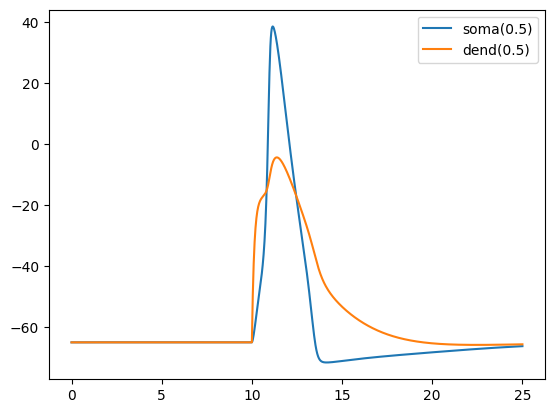

In [18]:
%matplotlib inline

plt.plot(t, soma_v, label="soma(0.5)")
plt.plot(t, dend_v, label="dend(0.5)")
plt.legend()
plt.show()

In [20]:
syn_i = h.Vector().record(syn_._ref_i)

h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

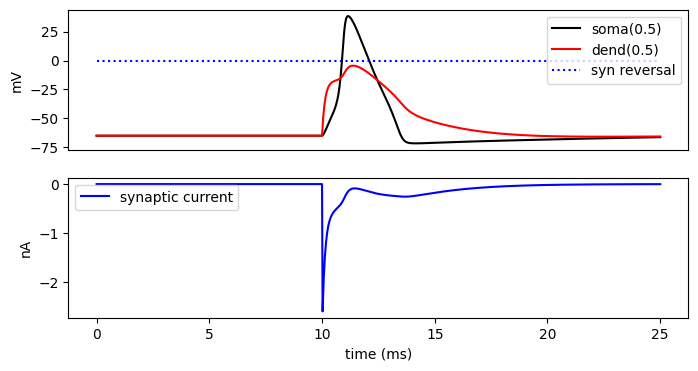

In [21]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(2, 1, 1)
soma_plot = ax1.plot(t, soma_v, color="black", label="soma(0.5)")
dend_plot = ax1.plot(t, dend_v, color="red", label="dend(0.5)")
rev_plot = ax1.plot(
    [t[0], t[-1]], [syn_.e, syn_.e], label="syn reversal", color="blue", linestyle=":"
)
ax1.legend()
ax1.set_ylabel("mV")
ax1.set_xticks([])  # Use ax2's tick labels

ax2 = fig.add_subplot(2, 1, 2)
syn_plot = ax2.plot(t, syn_i, color="blue", label="synaptic current")
ax2.legend()
ax2.set_ylabel(h.units("ExpSyn.i"))
ax2.set_xlabel("time (ms)")
plt.show()

In [42]:
syns = []
netcons = []

for source, target in zip(my_cells, my_cells[1:] + [my_cells[0]]):
    syn = h.ExpSyn(target.dend(0.5))
    nc = h.NetCon(source.soma(0.5)._ref_v, syn, sec=source.soma)
    nc.weight[0] = 0.05
    nc.delay = 5

    netcons.append(nc)
    syns.append(syn)

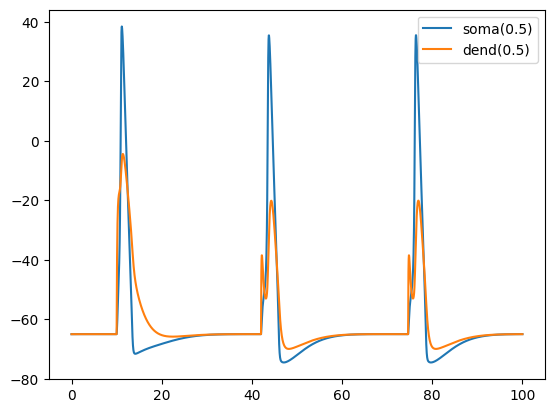

In [43]:
h.finitialize(-65 * mV)
h.continuerun(100 * ms)
plt.plot(t, soma_v, label="soma(0.5)")
plt.plot(t, dend_v, label="dend(0.5)")
plt.legend()
plt.show()

In [44]:
# record spike times in Vector objects uing NetCon.record

spike_times = [h.Vector() for nc in netcons]
for nc, spike_times_vec in zip(netcons, spike_times):
    nc.record(spike_times_vec)

In [47]:
h.finitialize(-65 * mV)
h.continuerun(100 * ms)

0.0

In [50]:
for i, spike_times_vec in enumerate(spike_times):
    print("cell {} : {}".format(i, list(spike_times_vec)))

cell 0 : [10.925000000099914, 43.55000000010134, 76.17500000010875]
cell 1 : [17.450000000099543, 50.075000000102825, 82.70000000011024]
cell 2 : [23.975000000099172, 56.60000000010431, 89.22500000011172]
cell 3 : [30.5000000000988, 63.12500000010579, 95.7500000001132]
cell 4 : [37.02500000009986, 69.65000000010727]


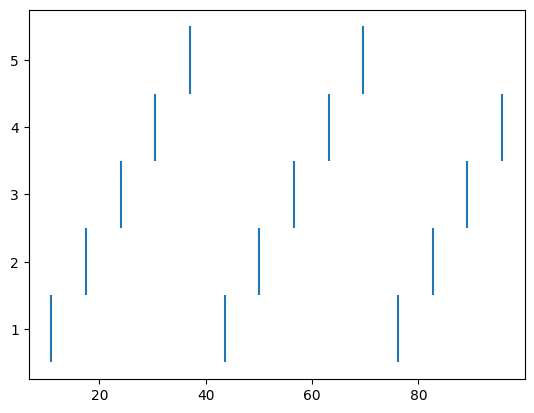

In [51]:
# intuitive imaging - raster plot

plt.figure()

for i, spike_times_vec in enumerate(spike_times):
    plt.vlines(list(spike_times_vec), i+0.5, i+1.5)

plt.show()

In [54]:
print((netcons[0]))

NetCon[51]


In [55]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
   `|       BallAndStick[0].dend(0-1)
|-|       BallAndStick[0].soma(0-1)
   `|       BallAndStick[0].dend(0-1)
|-|       BallAndStick[1].soma(0-1)
   `|       BallAndStick[1].dend(0-1)
|-|       BallAndStick[2].soma(0-1)
   `|       BallAndStick[2].dend(0-1)
|-|       BallAndStick[3].soma(0-1)
   `|       BallAndStick[3].dend(0-1)
|-|       BallAndStick[4].soma(0-1)
   `|       BallAndStick[4].dend(0-1)



1.0